# What's happening below? 
# Let's see
### I have provided a dataset ~5k images,yeah it is unlabelled data.So I'm going to label the data! <br> Wait,are you going to do it manually ? <br> oh dude you're so brave!! <br> <img src="https://github.com/naveenjoshii/gifsss/blob/master/no.gif?raw=true" width="300" height="150"> <br> My program will do that for me !!


In [1]:
# Importing the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans

In [2]:
DATASET_PATH = "../input/datasetavantari/dataset"

In [3]:
Images_list = os.listdir(DATASET_PATH)

In [4]:
def show_imgs_in_dataset(Images,base_path):
    '''
    Display's the images in our dataset in 4*4 grid i.e 16 images
    
    Arguments:
    X: list of images names (dtype : List)
    base_path : Path to the base dataset (dtype : String)
    
    Returns: None 
    '''
    k=0
    row = 4 # can change later
    col = 4 # can change later
    plt.figure(figsize=(8, 8))
    # loop over row and col
    for i in range(0,row):
        for j in range(0,col):
            # joining image name to base path
            path = base_path + "/"+Images[k]
            # loading and resize the image
            image = load_img(path, target_size=(224, 224))
            # specify where to plot the subplot
            plt.subplot2grid((row,col),(i,j))
            # show image in particular subgrid
            plt.imshow(image)
            k = k+1
    # show the plot
    plt.show()

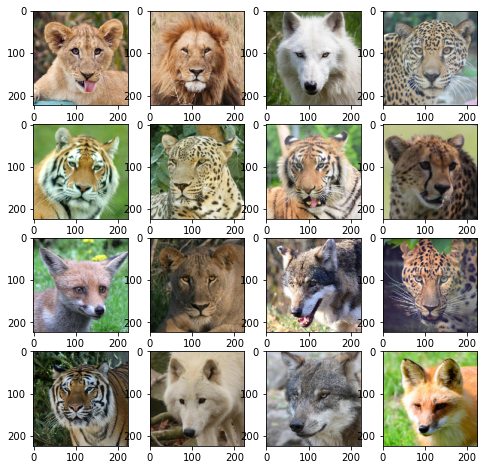

In [5]:
show_imgs_in_dataset(Images_list,DATASET_PATH)

In [6]:
# input shape
INPUT_SHAPE = (224,224,3) # can change later. NOTE : More Computation Power req if it is high

In [7]:
# load the VGG16 network
# remove the top dense layers, include_top=False
model = VGG16(weights="imagenet", include_top=False,input_shape = INPUT_SHAPE)
# let's see the layers behind our model
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [8]:
def create_features(Images,base_path, pre_model):
    '''
    Generates features for all the images in the dataset 
    provided using pretrained model
    
    Arguments 
    base_path : Path that specifies our dataset (dtype : String)
    pre_model : instance of our pre-trained model (dtype : keras.Model)
    
    Returns : Returns the n-D array of 1-D array feature 
              for each image (dtype : numpy.ndarray)
    
    '''
    
    x_scratch = []
    for image in Images:
        #appending image name to the base path
        imagePath = base_path+"/"+image
        # Loading and resizing image
        image = load_img(imagePath, target_size=INPUT_SHAPE)
        # Convert the image pixels to a numpy array
        image = img_to_array(image)
        # expanding the dimensions ex our image shape is (224,224,3) so far 
        # but if we expand the dimensions it becomes (1, 224, 224, 3)
        image = np.expand_dims(image, axis=0)
        # subtracting the mean RGB pixel intensity from the ImageNet dataset
        image = imagenet_utils.preprocess_input(image)
        # add the image to the batch
        x_scratch.append(image)
    #to get (n, 224, 224, 3) as the dim of images 
    # where n is the number of images processed
    # it will return n-d array of features with shape (4738, 224, 224, 3) 
    # note:our dataset size is 4738
    x = np.vstack(x_scratch)
    # Pass x into pre_model to get encoded features
    features = pre_model.predict(x, batch_size=32)
    # if we pass one image through our model
    # it will give you the feature array of shape (7, 7, 512)
    # we need to convert the feature matrix to 1-D array 
    # which shape is (25088,) NOTE : 7*7*512 = 25088
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return features_flatten

In [9]:
train_features_flatten = create_features(Images_list,DATASET_PATH, model)

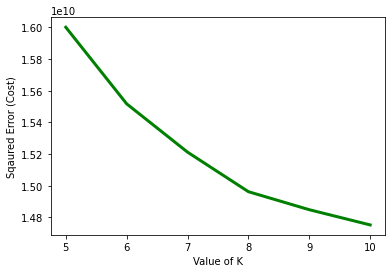

In [10]:
cost =[]
k = []
for i in range(5,11):
    KM = KMeans(n_clusters = i,  random_state=0) 
    KM.fit(train_features_flatten) 
	# calculates squared error 
	# for the clustered points
    cost.append(KM.inertia_)
    k.append(i)
# plot the cost against K values 
plt.plot(range(5,11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot 

#### Here we can see the drop in the sum of squared distance starts to slow down after k=8. <br> Hence 8 is the optimal number of clusters for our analysis

In [11]:
#initalize KMeans 
KM = KMeans(n_clusters = 8,  random_state=0)
#fit our features to Kmeans
KM.fit(train_features_flatten)

KMeans(random_state=0)

In [12]:
# this will store key as cluster and  value as respective 
# indexes of our Imagelist in dictionary
d = {i: np.where(KM.labels_ == i) for i in range(KM.n_clusters)}

In [13]:
# storing all the values of above d in list
all=[]
for i in range(KM.n_clusters):
    all.append(list(d[i][0]))

In [14]:
def show_imgs(Images,base_path,clus_index,clus):
    '''
    Displays the images of Image list where index belongs to clus_index list 
    
    Arguments
    Images : List of all images paths (dtype : list)
    base_path : Path that specifies our dataset (dtype : String)
    clus_index : list of index values (dtype : list)
    clus : cluster name (dtype : String)
    
    Returns : None
    
    '''
    plt.figure(figsize=(15,15))
    k = 0
    for i in range(0,2):
        for j in range(0,10):
            p = base_path + "/"+Images[clus_index[k]]
            image = load_img(p, target_size=(224, 224))
            plt.title(clus)
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(image)
            k = k+1
    plt.show()

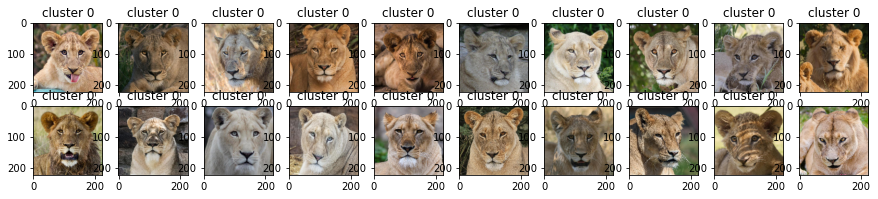

In [15]:
show_imgs(Images_list,DATASET_PATH,all[0],"cluster "+str(0))

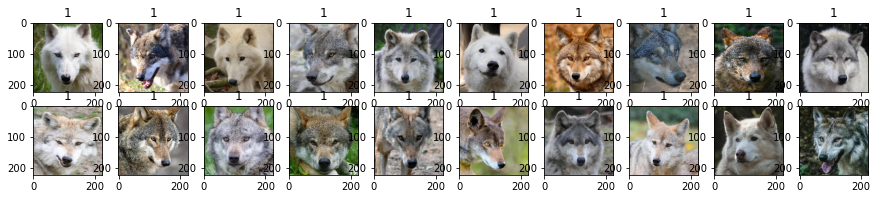

In [16]:
show_imgs(Images_list,DATASET_PATH,all[1],1)

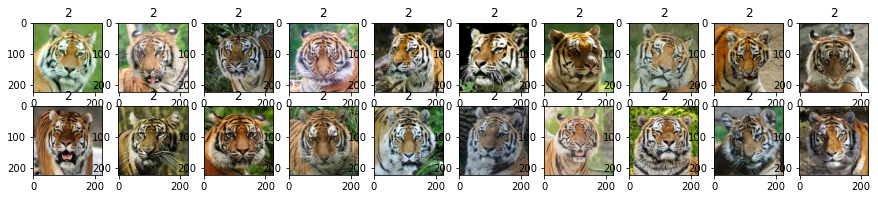

In [17]:
show_imgs(Images_list,DATASET_PATH,all[2],2)

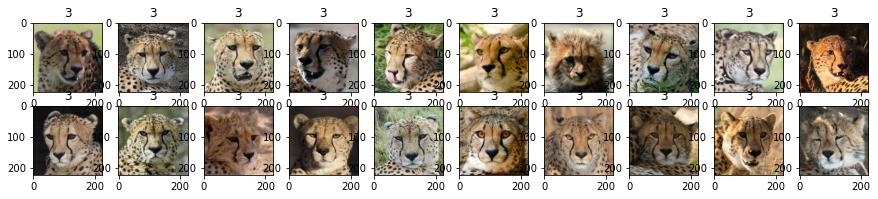

In [18]:
show_imgs(Images_list,DATASET_PATH,all[3],3)

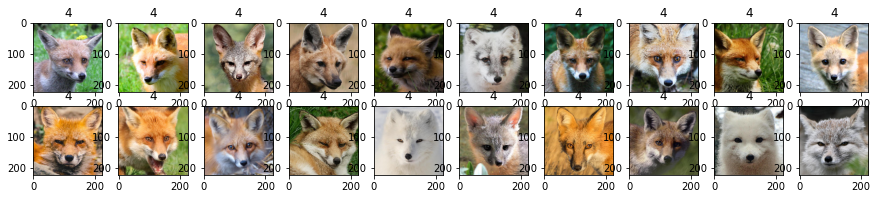

In [19]:
show_imgs(Images_list,DATASET_PATH,all[4],4)

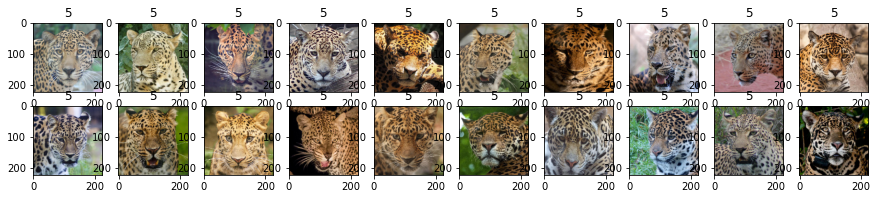

In [20]:
show_imgs(Images_list,DATASET_PATH,all[5],5)

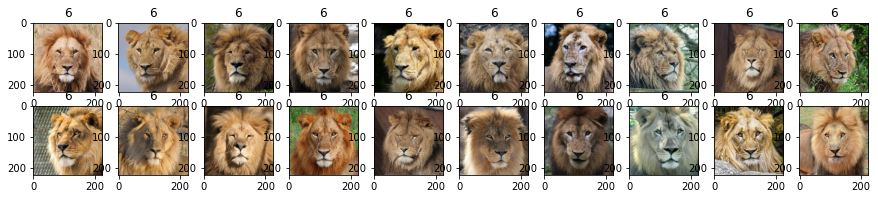

In [21]:
show_imgs(Images_list,DATASET_PATH,all[6],6)

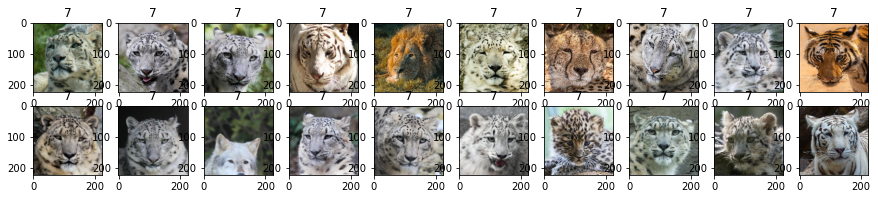

In [22]:
show_imgs(Images_list,DATASET_PATH,all[7],7)

<!-- <img src="https://github.com/naveenjoshii/gifsss/blob/master/wow.gif?raw=true"> -->
<table><tr><td><img src='https://github.com/naveenjoshii/gifsss/blob/master/wow.gif?raw=true' style="height:200px;width:200px"></td><td><img src='https://github.com/naveenjoshii/gifsss/blob/master/dude.gif?raw=true' style="height:200px;width:200px"></td></tr></table>

In [23]:
def get_paths(Images,base_path,clus_index,clus):
    '''
    creates a data frame with columns image and cluster 
    image value as the path of image and the respective cluster  
    
    Arguments
    Images : List of all images paths (dtype : list)
    base_path : Path that specifies our dataset (dtype : String)
    clus_index : list of index values (dtype : list)
    clus : cluster value (dtype : int)
    
    Returns : Data Frame ['image','cluster'] (dtype : pandas.dataframe)
    
    '''
    d = []
    k=0
    # iterate through each index of respective cluster
    for i in clus_index:
        x = base_path + "/"+Images[i]
        y = str(clus)
        d.append([x,y])
    df=pd.DataFrame(d,columns=['image','cluster'])
    return df

In [24]:
#collecting data frames for each cluster
clus = 0
final_clus = []
for i in all:
    paths = get_paths(Images_list,DATASET_PATH,i,clus)
    final_clus.append(paths)
    clus = clus+1

In [25]:
# concatinate the all data frames vertically 
result = pd.concat(final_clus,axis=0)

In [26]:
# length of data frame
len(result)

4738

In [27]:
# let's see what result data frame got
result.head()

,image,cluster
0,../input/datasetavantari/dataset/2345.jpg,0
1,../input/datasetavantari/dataset/2853.jpg,0
2,../input/datasetavantari/dataset/458.jpg,0
3,../input/datasetavantari/dataset/4177.jpg,0
4,../input/datasetavantari/dataset/2478.jpg,0


In [28]:
# save the data frame to csv for further implementation
result.to_csv('label-data-avantari.csv',index=False)

<img src="https://github.com/naveenjoshii/gifsss/blob/master/v1done.gif?raw=true">